In [1]:
!pip install torch

In [2]:
import torch
from from_scratch_transformer.transformer import Transformer
from from_scratch_transformer.layers import Input, Softmax

torch.set_default_dtype(torch.float32)
if torch.cuda.is_available():
     torch.set_default_device(0)
     print("Running on the GPU")
else:
     print("Running on the CPU")

# Hyperparameters
seq_len       = 100    
epochs        = 2
learning_rate = 0.1

# Model dimensions
d_model    = 512      # embedding size
num_heads  = 8        # Number of heads in each attention block
d_ff       = 2048     # FF hidden dim 
num_layers = 2     # number of decoder blocks

# Load data
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Build vocab
chars = sorted(set(text))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

# Encode text as ids
data = torch.tensor([stoi[ch] for ch in text], dtype=torch.long)

def get_batch(start):
    x = data[start : start + seq_len]          # [T]
    y = data[start + 1 : start + 1 + seq_len]  # [T]
    return x, y

# i nit model
model = Transformer(vocab_size, d_model, num_heads, d_ff, num_layers)
all_preds = []
# Training loop
for epoch in range(1, epochs + 1):
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0

    steps = 0
    for i in range(0, data.size(0) - seq_len - 1, seq_len):
        x_seq, y_seq = get_batch(i)   

        # Forward
        out_lin = model.forward(x_seq)   # out_lin.output: [T, V]
        logits  = out_lin.output         
        T, V    = logits.shape

        # Compute predictions
        preds = logits.argmax(dim=1)    
        # all_preds.append(preds)
        # print(preds)
        next_char = itos[preds[-1].item()]
        all_preds.append(next_char)
        total_correct += (preds == y_seq).sum().item()
        total_tokens  += T

        # one hot encode targets
        target_onehot = torch.zeros_like(logits)
        target_onehot[torch.arange(T), y_seq] = 1.0
        target_layer = Input(T, V)
        target_layer.set(target_onehot)

        # Loss
        loss_layer = Softmax(out_lin, target_layer)
        loss_layer.forward()
        loss = loss_layer.output

        # Backward
        loss_layer.backward()
        model.backward()

        # Update and clear
        model.step(learning_rate)
        loss_layer.clear_grad()
        model.clear_grad()

        total_loss += loss.item()
        steps += 1
        if steps % 500 == 0:
            print(f'Epoch {epoch}/{epochs} — Step {steps} — Loss: {loss.item():.4f}')

    avg_loss = total_loss / steps if steps > 0 else float('nan')
    accuracy = total_correct / total_tokens if total_tokens > 0 else float('nan')
    print(f'Epoch {epoch}/{epochs} — avg_loss: {avg_loss:.4f}, accuracy: {accuracy:.2%}')



Running on the CPU
Epoch 1/2 — Step 500 — Loss: 3.3071


KeyboardInterrupt: 

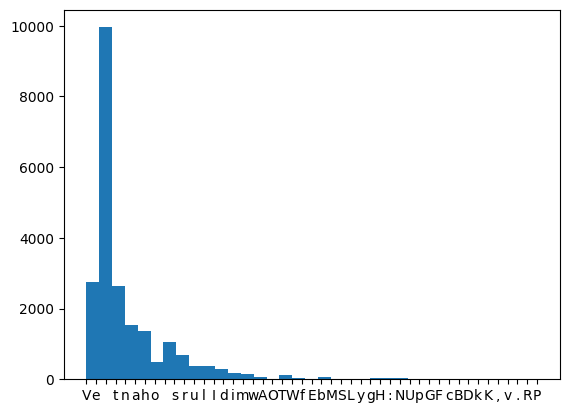

In [5]:
import matplotlib.pyplot as plt
plt.hist(all_preds, bins = 35)
plt.show()

In [6]:
def generate(prompt: str, max_gen: int = 100) -> str:
    # Encode prompt to token ids
    context = torch.tensor([stoi.get(ch, 0) for ch in prompt], dtype=torch.long)

    # Generate one token at a time
    for _ in range(max_gen):
        # Forward pass
        out_lin = model.forward(context)
        logits = out_lin.output  
        # Take last tokens logits
        next_logits = logits[-1]
        # argmax (greedy apporach)
        next_id = int(torch.argmax(next_logits).item())
        # Append to context
        context = torch.cat([context, torch.tensor([next_id], dtype=torch.long)])

    generated_ids = context[len(prompt):].tolist()
    return ''.join(itos[i] for i in generated_ids)


In [10]:
prompt = input("Enter prompt: ")
length = int(input("Max generation length: "))
completion = generate(prompt, max_gen=length)
print(f"\nGenerated: {prompt + completion}")


Generated: my biggest regret is that I will never be able toutherere theeeeeeeeeeeeeeeeererererereererererererererererererererererererererererererererererererer
